In [1]:
import pandas as pd  # type: ignore
import numpy as np  # type: ignore

import matplotlib.pyplot as plt  # type: ignore
from matplotlib.ticker import MaxNLocator  # type: ignore

from sklearn.manifold import TSNE  # type: ignore
from sklearn.decomposition import PCA  # type: ignore
from sklearn.preprocessing import StandardScaler  # type: ignore

from sklearn.model_selection import train_test_split  # type: ignore
from sklearn.linear_model import LinearRegression  # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import json
import lightgbm as lgb

import dask.dataframe as dd

SEED = 42
s = 1000

def get_darth_results_path(ds_name, k, nlist, nprobe, qs, tr, ipi, mpi):
    return f"/home/mchatzakis/cfaiss/experiments/ivf-results/darth/{ds_name}/k{k}/nlist{nlist}_nprobe{nprobe}_qs{qs}_tr{float(tr):.2f}_ipi{ipi}_mpi{mpi}.txt"

def get_plain_ivf_results_path(ds_name, k, nlist, nprobe, qs):
    return f"/home/mchatzakis/cfaiss/experiments/ivf-results/plain-ivf/testing/{ds_name}/k{k}/nlist{nlist}_nprobe{nprobe}_qs{qs}.txt"

def get_detailed_testing_queries_results_path(ds_name, k, nlist, nprobe, qs, li):
    return f"/data/mchatzakis/et_training_data/ivf/training-data-generation/testing/{ds_name}/{k}/nlist{nlist}_nprobe{nprobe}_qs{qs}_li{li}.txt"

def get_darth_model_path(ds_name, nlist, nprobe, s, k, li):
    return f"/home/mchatzakis/cfaiss/predictor_models/ivf/darth/{ds_name}_nlist{nlist}_nprobe{nprobe}_s{s}_k{k}_nestim100_lr0.1_li{li}_rl0_all_feats.txt"

dataset_params = {
        "SIFT100M": {
            "M": 32,
            "efC": 500,
            "efS": 500,
            "color": "lightblue",
            "marker": "o",
            "li": 1,
            "label": "SIFT100M",
            "ivf_li": 50,
            "nlist": 10000,
            "nprobe": 150,
        },
        "DEEP100M": {
            "M": 32,
            "efC": 500,
            "efS": 750,
            "color": "plum",
            "marker": "x",   
            "li": 1,
            "label": "DEEP100M",
            "ivf_li": 50,
            "nlist": 10000,
            "nprobe": 150,
        },
        "GLOVE100": {
            "M": 16,
            "efC": 500,
            "efS": 500,
            "color": "orange",
            "marker": "^",
            "li": 1,
            "label": "GLOVE1M",
            "ivf_li": 20,
            "nlist": 1000,
            "nprobe": 100,
        },
        "GIST1M": {
            "M": 32,
            "efC": 500,
            "efS": 1000,
            "color": "lightgreen",
            "marker": "s",
            "li": 1,
            "label": "GIST1M",
            "ivf_li": 20,
            "nlist": 1000,
            "nprobe": 200,
        },
    }


PLOTS_DIR = "./../../experiments/ivf-revision-plots/"

In [2]:
SEED = 42
n_estimators = 100

index_metric_feats = ["step", "dists", "inserts"]
neighbor_distances_feats = ["first_nn_dist", "nn_dist", "furthest_dist"]
neighbor_stats_feats = ["avg_dist", "variance", "percentile_25", "percentile_50", "percentile_75"]
all_feats = index_metric_feats + neighbor_distances_feats + neighbor_stats_feats

columns_to_load = ["qid", "elaps_ms"] + all_feats + ["r", "feats_collect_time_ms"]

feature_classes = {
    #"index_metric_feats": index_metric_feats,
    #"neighbor_distances_feats": neighbor_distances_feats,
    #"neighbor_stats_feats": neighbor_stats_feats,
    #"index_metrics_and_neighbor_distances": index_metric_feats + neighbor_distances_feats,
    #"index_metrics_and_neighbor_stats": index_metric_feats + neighbor_stats_feats,
    #"neighbor_distances_and_neighbor_stats": neighbor_distances_feats + neighbor_stats_feats,
    "all_feats": all_feats,
}


all_k_values = ["50"]
all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]

for ds_name in all_datasets:
    mse_per_k = []
    mae_per_k = []
    r2_per_k = []
    max_error_per_k = []
    
    nlist = dataset_params[ds_name]["nlist"]
    nprobe = dataset_params[ds_name]["nprobe"]
    li = dataset_params[ds_name]["ivf_li"]
    
    for k in all_k_values:
        feats = all_feats
        model_file = get_darth_model_path(ds_name, nlist, nprobe, 10000, k, li)
        model = lgb.Booster(model_file=model_file)
        
        testing_data_df_dask = dd.read_csv(get_detailed_testing_queries_results_path(ds_name, k, nlist, nprobe, 1000, li), usecols=columns_to_load)
        testing_data_df = testing_data_df_dask.compute()
        testing_y_true = testing_data_df["r"]            
                    
        validation_X = testing_data_df[feats]
        validation_y_pred = model.predict(validation_X)
        mse = mean_squared_error(testing_y_true, validation_y_pred)
        mae = mean_absolute_error(testing_y_true, validation_y_pred)
        r2 = r2_score(testing_y_true, validation_y_pred)
        max_error = np.max(np.abs(testing_y_true - validation_y_pred))
        
        mse_per_k.append(mse)
        mae_per_k.append(mae)
        r2_per_k.append(r2)
        max_error_per_k.append(max_error)
        
        #print(f"    {ds_name} k={k} => mse: {mse:.4f}, mae: {mae:.4f}, r2: {r2:.4f}")

    mse_ds = np.mean(mse_per_k)
    mae_ds = np.mean(mae_per_k)
    r2_ds = np.mean(r2_per_k)
    max_error_ds = np.mean(max_error_per_k)
    
    print(f"{ds_name} => mse: {mse_ds:.4f}, mae: {mae_ds:.4f}, r2: {r2_ds:.2f}")
                     

SIFT100M => mse: 0.0030, mae: 0.0280, r2: 0.84
DEEP100M => mse: 0.0031, mae: 0.0255, r2: 0.82
GLOVE100 => mse: 0.0020, mae: 0.0110, r2: 0.91
GIST1M => mse: 0.0039, mae: 0.0337, r2: 0.84


In [3]:
# Load the dataconf from a file:
IPI_DIV = 2
MPI_DIV = 10
interval_conf = {}
with open(f"../../experiments/generated_json/ivf/ivf_darth_params_ipi{IPI_DIV}_mpi{MPI_DIV}.json") as f:
    interval_conf = json.load(f)
print(interval_conf.keys(), interval_conf["SIFT100M"].keys(), interval_conf["SIFT100M"]["50"].keys())

dict_keys(['SIFT100M', 'DEEP100M', 'GIST1M', 'GLOVE100']) dict_keys(['50']) dict_keys(['0.8', '0.85', '0.9', '0.95', '0.99', '1.0'])


In [4]:
# Calculate for all datasets and all k-s the average recall vs the target recall
all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]
all_k_values = ["50"]
all_r_targets = ["0.8", "0.85", "0.9", "0.95", "0.99"]

all_speedups = [] #meant to extract analytics

ds_recalls = {} # k -> dataset -> [recall, std, qut, speedup for each r_target]

for k in all_k_values:
    ds_recalls[k] = {}
    print(f"k: {k}")
    for ds_name in all_datasets:
        nlist = dataset_params[ds_name]["nlist"]
        nprobe = dataset_params[ds_name]["nprobe"]
        li = dataset_params[ds_name]["ivf_li"]
        print(f"    Dataset: {ds_name}")
        ds_recalls[k][ds_name] = []
        
        for r_target in all_r_targets:
            ipi = interval_conf[ds_name][k][r_target]["ipi"]
            mpi = interval_conf[ds_name][k][r_target]["mpi"]
            r_target = float(r_target)
                
            #print(f"r_target: {r_target}, ipi: {ipi}, mpi: {mpi}")
                
            no_early_termination_df = pd.read_csv(get_plain_ivf_results_path(ds_name, k, nlist, nprobe, 1000), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
            darth_df = pd.read_csv(get_darth_results_path(ds_name, k, nlist, nprobe, 1000, r_target, ipi, mpi), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",])
            
            no_early_termination_df = no_early_termination_df[no_early_termination_df["r"] >= r_target]
            darth_df = darth_df[darth_df["qid"].isin(no_early_termination_df["qid"])]
            
            darth_recall_avg = darth_df["r_actual"].mean()
            darth_recall_std = darth_df["r_actual"].std()
            darth_df["r_actual"] = darth_df["r_actual"].apply(lambda x: round(x, 2))
            darth_rqut = len(darth_df[darth_df["r_actual"] < r_target])
            
            speedup = no_early_termination_df["elaps_ms"].mean() / darth_df["elaps_ms"].mean()
            
            per_query_speedups = no_early_termination_df["elaps_ms"] / darth_df["elaps_ms"]
            speedup_v2 = per_query_speedups.mean()
            
            all_speedups.append(speedup_v2)
            
            ds_recalls[k][ds_name].append([darth_recall_avg, darth_recall_std, darth_rqut, speedup, speedup_v2])
            
            print(f"        r_target: {r_target}, darth_recall_avg: {darth_recall_avg:.4f}, darth_recall_std: {darth_recall_std:.4f}, darth_rqut: {darth_rqut}, speedup_v2: {speedup_v2:.2f}x")            

print(f"Overall average speedup: {np.mean(all_speedups):.2f}x")
print(f"Overall median speedup: {np.median(all_speedups):.2f}x")
print(f"Max speedup: {np.max(all_speedups):.2f}x")

k: 50
    Dataset: SIFT100M
        r_target: 0.8, darth_recall_avg: 0.8583, darth_recall_std: 0.1100, darth_rqut: 250, speedup_v2: 11.77x
        r_target: 0.85, darth_recall_avg: 0.9003, darth_recall_std: 0.0880, darth_rqut: 247, speedup_v2: 8.00x
        r_target: 0.9, darth_recall_avg: 0.9372, darth_recall_std: 0.0647, darth_rqut: 189, speedup_v2: 6.19x
        r_target: 0.95, darth_recall_avg: 0.9735, darth_recall_std: 0.0371, darth_rqut: 170, speedup_v2: 4.55x
        r_target: 0.99, darth_recall_avg: 0.9972, darth_recall_std: 0.0098, darth_rqut: 81, speedup_v2: 2.29x
    Dataset: DEEP100M
        r_target: 0.8, darth_recall_avg: 0.8665, darth_recall_std: 0.1225, darth_rqut: 249, speedup_v2: 16.76x
        r_target: 0.85, darth_recall_avg: 0.9066, darth_recall_std: 0.0982, darth_rqut: 238, speedup_v2: 12.56x
        r_target: 0.9, darth_recall_avg: 0.9387, darth_recall_std: 0.0720, darth_rqut: 214, speedup_v2: 9.68x
        r_target: 0.95, darth_recall_avg: 0.9725, darth_recall_s

        r_target: 0.9, darth_recall_avg: 0.9364, darth_recall_std: 0.0656, darth_rqut: 206, speedup_v2: 4.86x
        r_target: 0.95, darth_recall_avg: 0.9715, darth_recall_std: 0.0386, darth_rqut: 222, speedup_v2: 3.27x
        r_target: 0.99, darth_recall_avg: 0.9974, darth_recall_std: 0.0095, darth_rqut: 87, speedup_v2: 1.78x
Overall average speedup: 13.64x
Overall median speedup: 8.05x
Max speedup: 41.79x


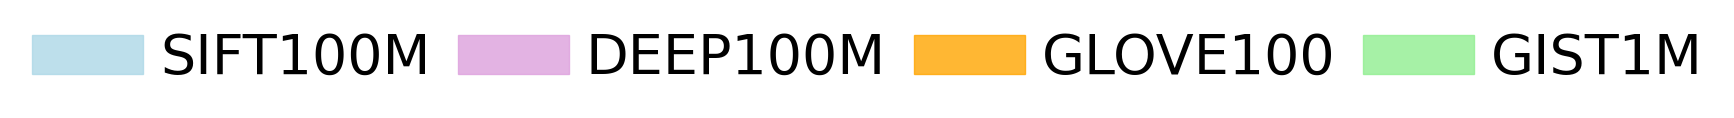

Fig saved at ./../../experiments/ivf-revision-plots/summary_recall_vs_target_recall_k50.pdf


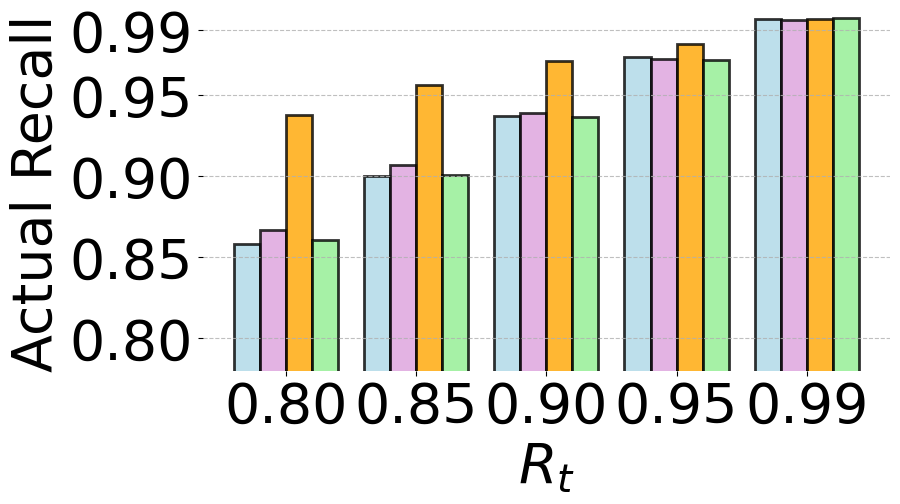

Fig saved at ./../../experiments/ivf-revision-plots/summary_speedup_vs_target_recall_k50.pdf


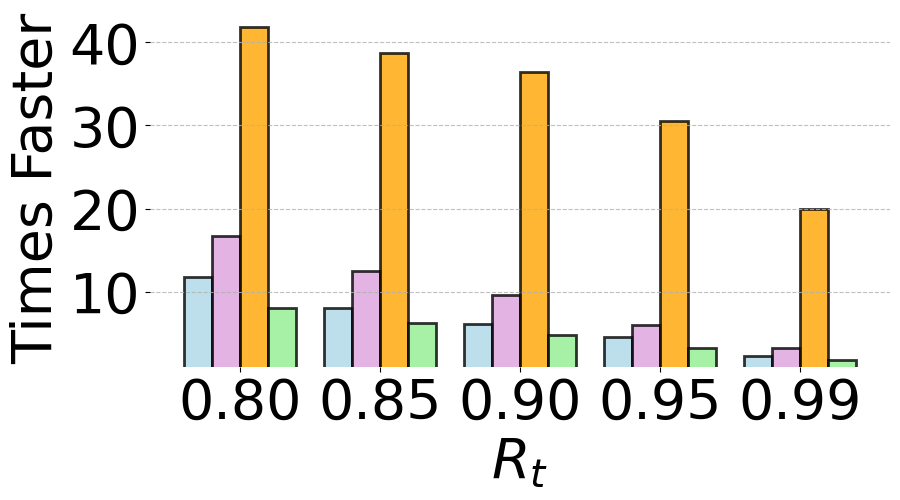

In [4]:
all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]
all_k_values = ["50"]
all_r_targets = ["0.8", "0.85", "0.9", "0.95", "0.99"]

plt.rcParams.update({"font.size": 40})

fig_legend, ax_legend = plt.subplots(figsize=(8, 1))
legend_elements = [Patch(facecolor=dataset_params[ds_name]["color"], edgecolor=dataset_params[ds_name]["color"], alpha=0.8, label=ds_name) for ds_name in ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]]
ax_legend.legend(handles=legend_elements, loc='center', ncol=4, frameon=False, handletextpad=0.3,  columnspacing=0.5, labelspacing=0.3 )
ax_legend.axis('off')
fig_legend.savefig(f"{PLOTS_DIR}summary_speedups_legend_only.pdf", bbox_inches="tight")
plt.show()
plt.close(fig_legend)

for k in all_k_values:
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    x = np.arange(len(all_r_targets))
    for i, ds_name in enumerate(all_datasets):
        recalls = []
        x_positions = x + i * bar_width

        for j, r_target in enumerate(all_r_targets):
            recall = ds_recalls[k][ds_name][j][0]
            recall_std = ds_recalls[k][ds_name][j][1]
            recalls.append(recall)
            std = recall_std
            ax.bar(x_positions[j], recall, bar_width, color=dataset_params[ds_name]["color"], alpha=0.8, edgecolor='black', linewidth=2)
            
    ax.set_xticks(x + (len(all_datasets) - 1) * bar_width / 2)
    ax.set_yticks([float(r) for r in [0.80, 0.85, 0.90, 0.95, 0.99]])
    x_tick_labels = ["0.80", "0.85", "0.90", "0.95", "0.99"]
    ax.set_xticklabels(x_tick_labels)
    ax.set_xlabel(r"$R_t$")
    ax.set_ylabel("Actual Recall")
    #ax.set_xticklabels([str(t) for t in all_r_targets])
    ax.grid(alpha=0.8, axis='y', linestyle='--')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_ylim(0.78, 1.00)
    #ax.tick_params(axis='x', labelsize=38)
    fig.tight_layout()
    savepath = f"{PLOTS_DIR}summary_recall_vs_target_recall_k{k}.pdf"
    fig.savefig(savepath, bbox_inches='tight')
    print(f"Fig saved at {savepath}")
    plt.show()
    plt.close(fig)
    
    # SPEEDUP PLOT
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    x = np.arange(len(all_r_targets))
    max_speedup = -1
    for i, ds_name in enumerate(all_datasets):
        x_positions = x + i * bar_width
        speedup_version_to_use=4
        speedups = []
        for j, r_target in enumerate(all_r_targets):
            speedup = ds_recalls[k][ds_name][j][speedup_version_to_use]
            if speedup > max_speedup:
                max_speedup = speedup
            speedups.append(speedup)
            ax.bar(x_positions[j], speedup, bar_width, color=dataset_params[ds_name]["color"], alpha=0.8, edgecolor='black', linewidth=2)
    
    ax.set_xticks(x + (len(all_datasets) - 1) * bar_width / 2)
    ax.set_xlabel(r"$R_t$")
    ax.set_ylabel("Times Faster")
    ax.set_yticks([10, 20, 30, 40])
    #ax.set_yticks(np.arange(1, max_speedup + 1, 5))
    ax.set_ylim(bottom=1)
    x_tick_labels = ["0.80", "0.85", "0.90", "0.95", "0.99"]
    ax.set_xticklabels(x_tick_labels)
    ax.grid(alpha=0.8, axis='y', linestyle='--')
    for spine in ax.spines.values():
        spine.set_visible(False)
    #ax.tick_params(axis='x', labelsize=38)
    fig.tight_layout()
    filename = f"{PLOTS_DIR}summary_speedup_vs_target_recall_k{k}.pdf"
    fig.savefig(filename, bbox_inches='tight')
    print(f"Fig saved at {filename}")
    plt.show()
    plt.close(fig)

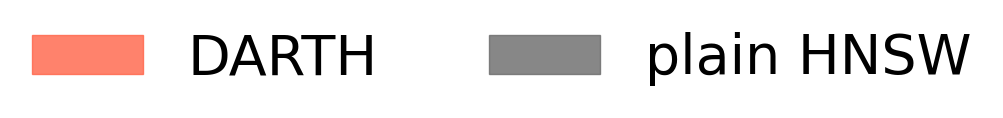

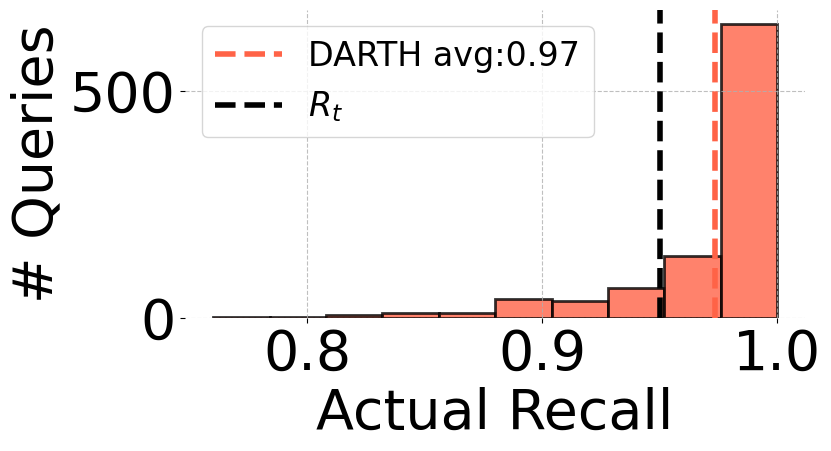

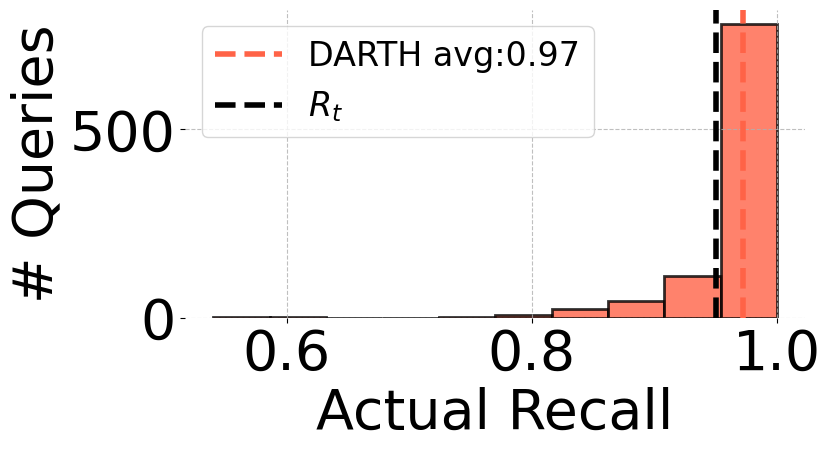

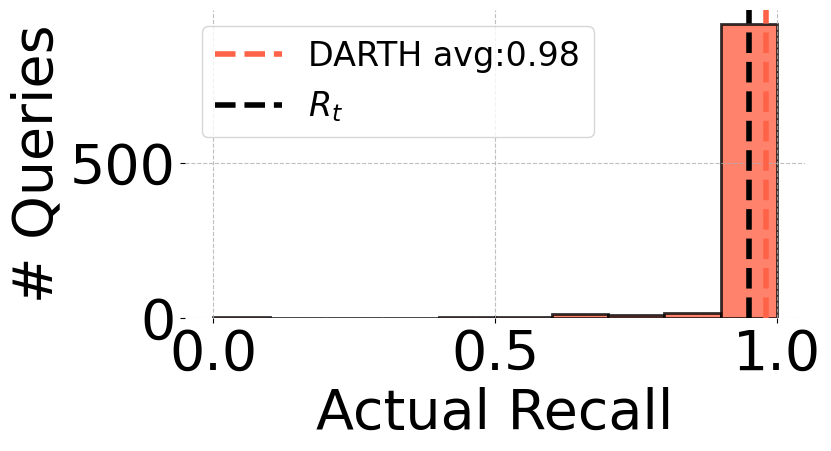

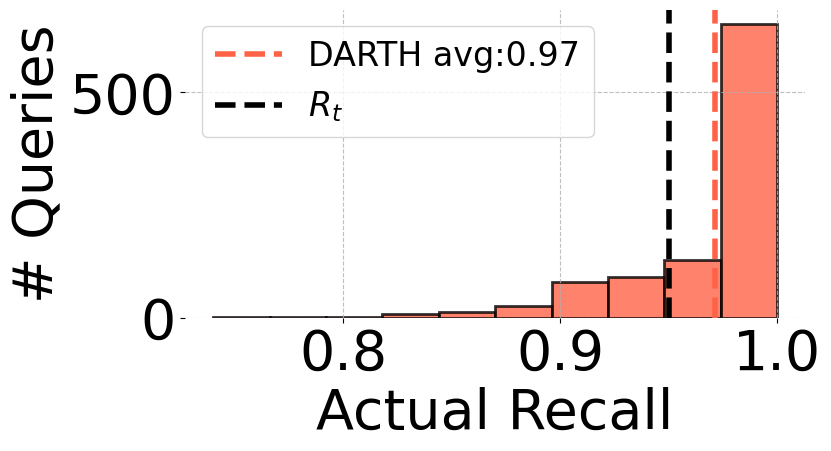

In [37]:
plt.rcParams.update({"font.size": 40}) 

fig_legend, ax_legend = plt.subplots(figsize=(8, 1))  # Adjust the figsize for better alignment
legend_elements = [
    Patch(facecolor="tomato", edgecolor="tomato", alpha=0.8, label="DARTH"),
    Patch(facecolor="dimgray", edgecolor="dimgray", alpha=0.8, label="plain HNSW"),
    #Line2D([0], [0], color="tomato", linestyle="dashed", linewidth=5, label="DARTH Avg."),
    #Line2D([0], [0], color="dimgray", linestyle="dashed", linewidth=5, label="HNSW No Early Termination Avg."),
    #Line2D([0], [0], color="black", linestyle="dashed", linewidth=5, label=r"$R_t$"), 
]
ax_legend.legend(handles=legend_elements, loc='center', ncol=5, frameon=False)

ax_legend.axis('off')
#fig_legend.savefig(f"{PLOTS_DIR}perf_legend_only.pdf", bbox_inches="tight")
plt.show()
plt.close(fig_legend)

s = 1000
all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]
all_k_values = ["50"]
for ds_name in all_datasets:
    for k in all_k_values:
        nlist = dataset_params[ds_name]["nlist"]
        nprobe = dataset_params[ds_name]["nprobe"]
        li = dataset_params[ds_name]["ivf_li"]
        r_targets = interval_conf[ds_name][k].keys()

        #if ds_name == "T2I100M":
        #    r_targets = ["0.8", "0.85", "0.9", "0.95"]
        #else:
        #r_targets = ["0.8", "0.85", "0.9", "0.95", "0.99"]
        r_targets = ["0.95"]

        for ir, r_target in enumerate(r_targets):
            ipi = interval_conf[ds_name][k][r_target]["ipi"]
            mpi = interval_conf[ds_name][k][r_target]["mpi"]
            r_target = float(r_target)
                        
            no_early_termination_df = pd.read_csv(get_plain_ivf_results_path(ds_name, k, nlist, nprobe, s), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
            baseline_mean = no_early_termination_df["elaps_ms"].mean()
            darth_df = pd.read_csv(get_darth_results_path(ds_name, k, nlist, nprobe, s, r_target, ipi, mpi), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",])
            elapsed_mean = darth_df["elaps_ms"].mean()
            predictor_calls_mean = darth_df["r_predictor_calls"].mean()
            no_early_termination_df = no_early_termination_df[no_early_termination_df["r"] >= r_target]
            darth_df = darth_df[darth_df["qid"].isin(no_early_termination_df["qid"])]
            
            fig_recall, ax_recall = plt.subplots(figsize=(8, 4))
            ax_recall.hist(darth_df["r_actual"], alpha=0.8, color="tomato", edgecolor="black", linewidth=2.0)
            r_actual_mean = darth_df["r_actual"].mean()
            ax_recall.axvline(r_actual_mean, color="tomato", linestyle="dashed", linewidth=4, label=f"DARTH avg:{r_actual_mean:.2f}")
            ax_recall.axvline(r_target, color="black", linestyle="dashed", linewidth=4, label=r"$R_t$")
            for spine in ax_recall.spines.values():
                spine.set_visible(False)
            
            #ax_recall.set_yscale("log")
            ax_recall.set_ylabel("# Queries")
            ax_recall.set_xlabel(f"Actual Recall")
            ax_recall.grid(alpha=0.8, linestyle="--")
            ax_recall.legend(fontsize=24)
            fig_recall.savefig(f"{PLOTS_DIR}perf_recall_{ds_name}_k{k}_{r_target}.pdf", bbox_inches="tight")
            plt.show()
            plt.close(fig_recall)
            
            #fig_predictor_calls, ax_predictor_calls = plt.subplots(figsize=(8, 4))
            #ax_predictor_calls.hist(darth_df["r_predictor_calls"], alpha=0.8, color="tomato", edgecolor="black", linewidth=2.0)
            #ax_predictor_calls.axvline(predictor_calls_mean, color="tomato", linestyle="dashed", linewidth=4, label=f"DARTH avg:{round(predictor_calls_mean)}")
            #for spine in ax_predictor_calls.spines.values():
            #    spine.set_visible(False)
            #ax_predictor_calls.set_ylabel("# Queries")
            #ax_predictor_calls.set_xlabel("Predictor Calls")
            #ax_predictor_calls.grid(alpha=0.8, linestyle="--")
            #ax_predictor_calls.legend(fontsize=24)
            #fig_predictor_calls.savefig(f"{PLOTS_DIR}perf_predictor_calls_{ds_name}_k{k}_{r_target}.pdf", bbox_inches="tight")
            #plt.show()
            #plt.close(fig_predictor_calls)

            

In [29]:
s = 1000
all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]
all_k_values = ["50"]
for ds_name in all_datasets:
    for k in all_k_values:
        nlist = dataset_params[ds_name]["nlist"]
        nprobe = dataset_params[ds_name]["nprobe"]
        li = dataset_params[ds_name]["ivf_li"]
        
        no_early_termination_df = pd.read_csv(get_plain_ivf_results_path(ds_name, k, nlist, nprobe, s), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
        plain_ivf_avg_recall = no_early_termination_df["r"].mean()
        print(f"{ds_name} k={k} plain ivf avg recall: {plain_ivf_avg_recall:.3f}")

       

SIFT100M k=50 plain ivf avg recall: 0.993
DEEP100M k=50 plain ivf avg recall: 0.994
GLOVE100 k=50 plain ivf avg recall: 0.997
GIST1M k=50 plain ivf avg recall: 0.998
